# **Process OD table from Synergy plate reader and make growth curves**

### **Extract tables from Excel files:** 
- From the *file with the incubation measures*, copy and paste the table below *"O.D. corrigida para 1 cm"* to another excel file. Then, save this new file as od600_tp.csv
- From the file with the *time point 0* measure, copy and paste the table next to *"O.D. corrigida para 1 cm"* to another excel file. Then, save this new file as od600_tp.csv
- *Additional time points beyond those in incubation*: od600_tpX, with X being the corresponding time point measured.

In [21]:
# Load packages
library(dplyr)
library(tidyr)
library(hms)
library(lubridate)
library(ggplot2)
library(purrr)
library(patchwork)
library(tidyverse)

### **Process single time points measure table (od_tp0 for instance)** 

In [22]:
# Read raw file (semicolon/comma decimal issue to handle)
raw <- read.csv("od600_tp0.csv", header = FALSE, skip = 1, na.strings = c("", "NA"))

# Set row names A-H and remove first column (empty)
rownames(raw) <- LETTERS[1:8]
raw <- raw[, -1]

# Replace commas with dots and convert to numeric (preserving matrix shape)
raw_numeric <- raw %>%
  mutate(across(everything(), ~ as.numeric(gsub(",", ".", .))))

# Generate well names in row-major order: A1–A12, B1–B12, ..., H1–H12
rows <- LETTERS[1:8]
cols <- 1:12
well_names <- unlist(lapply(rows, function(r) paste0(r, cols)))

# Flatten by row (to match well naming order)
values <- as.vector(t(as.matrix(raw_numeric)))
names(values) <- well_names

# Create final formatted data frame
formatted_df <- as.data.frame(t(values))
formatted_df <- formatted_df %>% mutate(Time = "00:00:00") %>% select(Time, everything())

print(formatted_df)

      Time    A1    A2    A3    A4 A5     A6 A7 A8 A9 A10 A11 A12    B1    B2
1 00:00:00 0.067 0.073 0.059 0.052 NA -0.001 NA NA NA  NA  NA  NA 0.063 0.054
     B3    B4 B5     B6 B7 B8 B9 B10 B11 B12    C1    C2    C3    C4 C5    C6
1 0.075 0.078 NA -0.002 NA NA NA  NA  NA  NA 0.067 0.058 0.052 0.066 NA 0.004
  C7 C8 C9 C10 C11 C12    D1    D2    D3    D4 D5     D6 D7 D8 D9 D10 D11 D12
1 NA NA NA  NA  NA  NA 0.059 0.063 0.052 0.064 NA -0.002 NA NA NA  NA  NA  NA
     E1    E2    E3    E4 E5 E6 E7 E8 E9 E10 E11 E12    F1    F2    F3    F4 F5
1 0.135 0.203 0.209 0.159 NA NA NA NA NA  NA  NA  NA 0.141 0.152 0.173 0.162 NA
  F6 F7 F8 F9 F10 F11 F12   G1    G2   G3    G4 G5 G6 G7 G8 G9 G10 G11 G12
1 NA NA NA NA  NA  NA  NA 0.16 0.158 0.18 0.226 NA NA NA NA NA  NA  NA  NA
     H1    H2    H3    H4 H5 H6 H7 H8 H9 H10 H11 H12
1 0.153 0.162 0.186 0.213 NA NA NA NA NA  NA  NA  NA


### **Combine OD tables and process them** 

In [23]:
# Load and clean `od600_tp.csv` (replace "," decimal and quotes)
od_tp <- read_csv("od600_tp.csv", na = c("", "NA")) %>%
  mutate(across(
    -Time,
    ~ .x %>%
      str_remove_all('"') %>%         # remove any surrounding quotes
      str_replace_all(",", ".") %>%   # convert decimal commas to dots
      as.numeric()
  ))

head(od_tp)

Rows: 97 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (36): A1, A2, A3, A4, A6, B1, B2, B3, B4, B6, C1, C2, C3, C4, C6, D1, D...
time  (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There were 36 warnings in `mutate()`.
The first warning was:
ℹ In argument: `across(...)`.
Caused by warning in `A1 %>% str_remove_all("\"") %>% str_replace_all(",", ".") %>% as.numeric()`:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 35 remaining warnings.”


Time,A1,A2,A3,A4,A6,B1,B2,B3,B4,⋯,F3,F4,G1,G2,G3,G4,H1,H2,H3,H4
<time>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
00:29:35,0.111,0.061,0.070,0.056,0.000,0.106,0.064,0.074,0.077,⋯,0.158,0.113,0.159,0.155,0.177,0.132,0.131,0.180,0.160,0.138
00:59:35,0.171,0.076,0.084,0.065,0.001,0.120,0.087,0.086,0.092,⋯,0.211,0.139,0.230,0.182,0.247,0.150,0.189,0.241,0.191,0.161
01:29:35,0.212,0.127,0.113,0.092,0.001,0.183,0.138,0.122,0.126,⋯,0.314,0.205,0.348,0.234,0.345,0.207,0.318,0.314,0.257,0.229
01:59:35,0.352,0.183,0.162,0.157,0.002,0.304,0.190,0.175,0.175,⋯,0.461,0.318,0.532,0.311,0.471,0.310,0.500,0.413,0.351,0.336
02:29:35,0.474,0.264,0.225,0.218,0.002,0.446,0.236,0.241,0.238,⋯,0.598,0.447,0.760,0.394,0.584,0.423,0.665,0.516,0.458,0.447
02:59:35,0.601,0.363,0.314,0.296,-0.001,0.559,0.292,0.336,0.362,⋯,0.773,0.621,1.007,0.524,0.738,0.611,0.781,0.651,0.605,0.599


In [24]:
common_cols <- intersect(colnames(formatted_df), colnames(od_tp))
common_cols

[1] "Time" "A1"   "A2"   "A3"   "A4"   "A6"   "B1"   "B2"   "B3"   "B4"  
[11] "B6"   "C1"   "C2"   "C3"   "C4"   "C6"   "D1"   "D2"   "D3"   "D4"  
[21] "D6"   "E1"   "E2"   "E3"   "E4"   "F1"   "F2"   "F3"   "F4"   "G1"  
[31] "G2"   "G3"   "G4"   "H1"   "H2"   "H3"   "H4"

In [25]:
# Reorder columns match between tables and convert both time columns to character
formatted_df_clean <- formatted_df %>%
  select(all_of(common_cols)) %>%
  mutate(Time = as.character(Time))

od_tp_clean <- od_tp %>%
  select(all_of(common_cols)) %>%
  mutate(Time = as.character(Time))

head(formatted_df_clean)
head(od_tp_clean)

,Time,A1,A2,A3,A4,A6,B1,B2,B3,B4,⋯,F3,F4,G1,G2,G3,G4,H1,H2,H3,H4
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,00:00:00,0.067,0.073,0.059,0.052,-0.001,0.063,0.054,0.075,0.078,⋯,0.173,0.162,0.16,0.158,0.18,0.226,0.153,0.162,0.186,0.213


Time,A1,A2,A3,A4,A6,B1,B2,B3,B4,⋯,F3,F4,G1,G2,G3,G4,H1,H2,H3,H4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
00:29:35,0.111,0.061,0.070,0.056,0.000,0.106,0.064,0.074,0.077,⋯,0.158,0.113,0.159,0.155,0.177,0.132,0.131,0.180,0.160,0.138
00:59:35,0.171,0.076,0.084,0.065,0.001,0.120,0.087,0.086,0.092,⋯,0.211,0.139,0.230,0.182,0.247,0.150,0.189,0.241,0.191,0.161
01:29:35,0.212,0.127,0.113,0.092,0.001,0.183,0.138,0.122,0.126,⋯,0.314,0.205,0.348,0.234,0.345,0.207,0.318,0.314,0.257,0.229
01:59:35,0.352,0.183,0.162,0.157,0.002,0.304,0.190,0.175,0.175,⋯,0.461,0.318,0.532,0.311,0.471,0.310,0.500,0.413,0.351,0.336
02:29:35,0.474,0.264,0.225,0.218,0.002,0.446,0.236,0.241,0.238,⋯,0.598,0.447,0.760,0.394,0.584,0.423,0.665,0.516,0.458,0.447
02:59:35,0.601,0.363,0.314,0.296,-0.001,0.559,0.292,0.336,0.362,⋯,0.773,0.621,1.007,0.524,0.738,0.611,0.781,0.651,0.605,0.599


In [26]:
# Combine data frames
od_combined <- bind_rows(formatted_df_clean, od_tp_clean)
head(od_combined)

,Time,A1,A2,A3,A4,A6,B1,B2,B3,B4,⋯,F3,F4,G1,G2,G3,G4,H1,H2,H3,H4
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,00:00:00,0.067,0.073,0.059,0.052,-0.001,0.063,0.054,0.075,0.078,⋯,0.173,0.162,0.160,0.158,0.180,0.226,0.153,0.162,0.186,0.213
2,00:29:35,0.111,0.061,0.070,0.056,0.000,0.106,0.064,0.074,0.077,⋯,0.158,0.113,0.159,0.155,0.177,0.132,0.131,0.180,0.160,0.138
3,00:59:35,0.171,0.076,0.084,0.065,0.001,0.120,0.087,0.086,0.092,⋯,0.211,0.139,0.230,0.182,0.247,0.150,0.189,0.241,0.191,0.161
4,01:29:35,0.212,0.127,0.113,0.092,0.001,0.183,0.138,0.122,0.126,⋯,0.314,0.205,0.348,0.234,0.345,0.207,0.318,0.314,0.257,0.229
5,01:59:35,0.352,0.183,0.162,0.157,0.002,0.304,0.190,0.175,0.175,⋯,0.461,0.318,0.532,0.311,0.471,0.310,0.500,0.413,0.351,0.336
6,02:29:35,0.474,0.264,0.225,0.218,0.002,0.446,0.236,0.241,0.238,⋯,0.598,0.447,0.760,0.394,0.584,0.423,0.665,0.516,0.458,0.447


In [27]:
# Reshape to long format
od_long <- od_combined %>%
  pivot_longer(
    cols = -Time,
    names_to = "well",
    values_to = "OD600"
  )

# Create metadata from column names
od_long <- od_long %>%
  mutate(
    strain = if_else(substr(well, 1, 1) %in% c("A", "B", "C", "D"), "1263", "1956"),
    carbon_source = case_when(
      grepl("1$", well) ~ "CLM_GLU",
      grepl("2$", well) ~ "CLM_Neu5Ac",
      grepl("3$", well) ~ "CLM_GMP9000",
      grepl("4$", well) ~ "CLM",
      TRUE ~ "Unknown"
    )
  ) 
head(od_long)

Time,well,OD600,strain,carbon_source
<chr>,<chr>,<dbl>,<chr>,<chr>
00:00:00,A1,0.067,1263,CLM_GLU
00:00:00,A2,0.073,1263,CLM_Neu5Ac
00:00:00,A3,0.059,1263,CLM_GMP9000
00:00:00,A4,0.052,1263,CLM
00:00:00,A6,-0.001,1263,Unknown
00:00:00,B1,0.063,1263,CLM_GLU


In [28]:
# Create a duration column (in hours)
od_long <- od_long %>%
  separate(Time, into = c("H", "M", "S"), sep = ":", convert = TRUE) %>%
  mutate(
    Time_hr = H + M / 60 + S / 3600
  ) %>%
  select(-H, -M, -S)  # optional: drop split columns
head(od_long)

well,OD600,strain,carbon_source,Time_hr
<chr>,<dbl>,<chr>,<chr>,<dbl>
A1,0.067,1263,CLM_GLU,0
A2,0.073,1263,CLM_Neu5Ac,0
A3,0.059,1263,CLM_GMP9000,0
A4,0.052,1263,CLM,0
A6,-0.001,1263,Unknown,0
B1,0.063,1263,CLM_GLU,0


In [29]:
# Remove "Unknown" before computing residuals
od_long <- od_long %>%
  filter(carbon_source != "Unknown")
head(od_long)

well,OD600,strain,carbon_source,Time_hr
<chr>,<dbl>,<chr>,<chr>,<dbl>
A1,0.067,1263,CLM_GLU,0
A2,0.073,1263,CLM_Neu5Ac,0
A3,0.059,1263,CLM_GMP9000,0
A4,0.052,1263,CLM,0
B1,0.063,1263,CLM_GLU,0
B2,0.054,1263,CLM_Neu5Ac,0


In [30]:
# Compute residuals (distance of each measure to the mean) and remove the biological replica more distant to the mean
## Calculate per group (strain, carbon_source, Time_hr) the mean OD600
group_means <- od_long %>%
  group_by(strain, carbon_source, Time_hr) %>%
  summarise(Mean_OD = mean(OD600, na.rm = TRUE), .groups = "drop")

head(group_means)

strain,carbon_source,Time_hr,Mean_OD
<chr>,<chr>,<dbl>,<dbl>
1263,CLM,0.0000000,0.06500
1263,CLM,0.4930556,0.06850
1263,CLM,0.9930556,0.07575
1263,CLM,1.4930556,0.11050
1263,CLM,1.9930556,0.17400
1263,CLM,2.4930556,0.22425


In [31]:
## Calculate, for each well, the overall "distance" from group means across all times
od_with_mean <- od_long %>%
  left_join(group_means, by = c("strain", "carbon_source", "Time_hr")) %>%
  mutate(residual = abs(OD600 - Mean_OD))

head(od_with_mean)

well,OD600,strain,carbon_source,Time_hr,Mean_OD,residual
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
A1,0.067,1263,CLM_GLU,0,0.0640,0.0030
A2,0.073,1263,CLM_Neu5Ac,0,0.0620,0.0110
A3,0.059,1263,CLM_GMP9000,0,0.0595,0.0005
A4,0.052,1263,CLM,0,0.0650,0.0130
B1,0.063,1263,CLM_GLU,0,0.0640,0.0010
B2,0.054,1263,CLM_Neu5Ac,0,0.0620,0.0080


In [32]:
## For each biological group (strain, condition, time), find the most deviant biological replicate
wells_to_remove <- od_with_mean %>%
  group_by(strain, carbon_source, Time_hr) %>%
  slice_max(residual, n = 1, with_ties = FALSE) %>%
  select(strain, carbon_source, Time_hr, well)

head(wells_to_remove)

strain,carbon_source,Time_hr,well
<chr>,<chr>,<dbl>,<chr>
1263,CLM,0.0000000,A4
1263,CLM,0.4930556,A4
1263,CLM,0.9930556,B4
1263,CLM,1.4930556,A4
1263,CLM,1.9930556,A4
1263,CLM,2.4930556,B4


In [33]:
## Remove those replicate entries from the original data
filtered_od <- od_long %>%
  anti_join(wells_to_remove, by = c("strain", "carbon_source", "Time_hr", "well")) 
head(filtered_od)

well,OD600,strain,carbon_source,Time_hr
<chr>,<dbl>,<chr>,<chr>,<dbl>
A1,0.067,1263,CLM_GLU,0
A3,0.059,1263,CLM_GMP9000,0
B1,0.063,1263,CLM_GLU,0
B2,0.054,1263,CLM_Neu5Ac,0
B4,0.078,1263,CLM,0
C1,0.067,1263,CLM_GLU,0


In [38]:
unique(df_summary_filtered$Condition)

[1] "CLM"         "CLM_GLU"     "CLM_GMP9000" "CLM_Neu5Ac"

In [34]:
## Summarize mean and SD per group (without the worst replicate)
df_summary_filtered <- filtered_od %>%
  group_by(strain, carbon_source, Time_hr) %>%
  summarise(
    OD_mean = mean(OD600, na.rm = TRUE),
    OD_SD = sd(OD600, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  rename(Isolate = strain, Condition = carbon_source, Time = Time_hr)

head(df_summary_filtered)

Isolate,Condition,Time,OD_mean,OD_SD
<chr>,<chr>,<dbl>,<dbl>,<dbl>
1263,CLM,0.0000000,0.06933333,0.007571878
1263,CLM,0.4930556,0.07266667,0.009291573
1263,CLM,0.9930556,0.07033333,0.004618802
1263,CLM,1.4930556,0.11666667,0.010066446
1263,CLM,1.9930556,0.17966667,0.008962886
1263,CLM,2.4930556,0.21966667,0.002886751


In [35]:
# Plot - trend

In [36]:
plot_isolate <- function(isolate_id, data) {
  df_sub <- filter(data, Isolate == isolate_id)
  
  # Calculate max time rounded up to nearest even number for axis limits
  max_time <- ceiling(max(df_sub$Time) / 2) * 2
  
  ggplot(df_sub, aes(x = Time, y = OD_mean, color = Condition, fill = Condition)) + 
    geom_smooth(method = "loess", span = 0.4, se = TRUE, size = 1, alpha = 0.3) +  # Loess curve with confidence interval
    ylab("OD (600 nm)") + 
    xlab("Time (h)") + 
    ggtitle(paste(isolate_id)) + 
    scale_color_manual(values = condition_colors) + 
    scale_fill_manual(values = condition_colors) + 
    theme_classic() +
    theme(
      plot.title = element_text(size = 16, hjust = 0.5),
      axis.title = element_text(size = 14),
      axis.text = element_text(size = 12),
      legend.title = element_text(size = 12),
      legend.text = element_text(size = 10)
    ) +
    scale_y_continuous(limits = c(0, 3), breaks = seq(0, 3, by = 0.5)) + 
    scale_x_continuous(
      limits = c(0, max_time),
      breaks = seq(0, max_time, by = 6),
      expand = c(0, 0)
    )
}

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


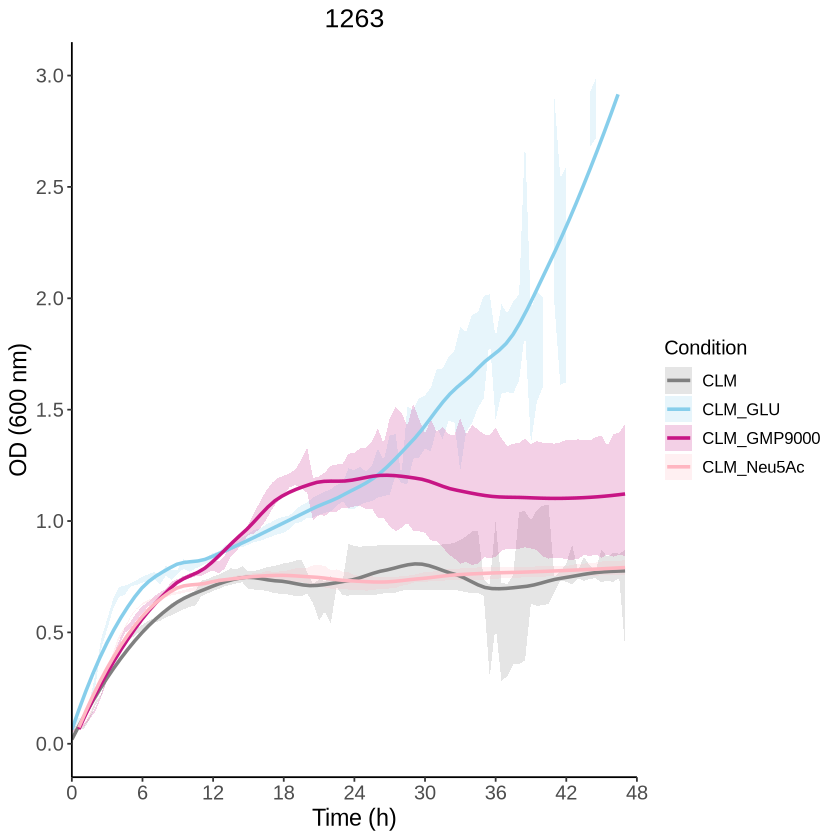

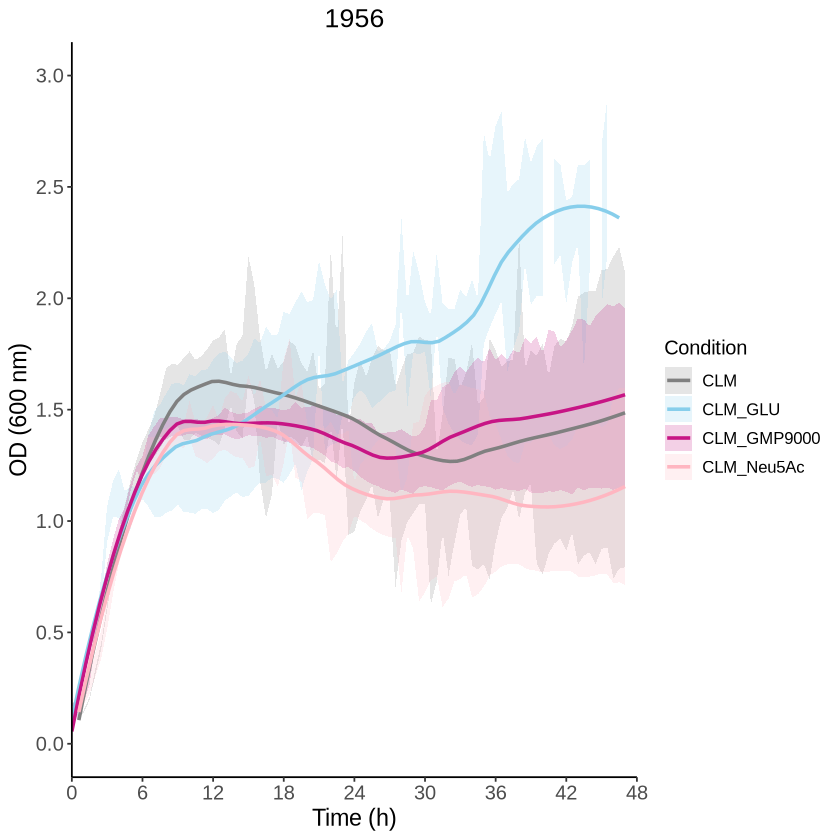

In [47]:
condition_colors <- c(
  "CLM" = "#808080",          # Gray
  "CLM_GLU" = "#87CEEB",      # Light Blue (SkyBlue)
  "CLM_GMP9000" = "#C71585",  # Dark Pink (MediumVioletRed)
  "CLM_Neu5Ac" = "#FFB6C1"    # Light Pink
)

plot1 <- plot_isolate("1263", df_summary_filtered)
plot2 <- plot_isolate("1956", df_summary_filtered)
plot1
plot2

In [40]:
ggsave("1263_300725.png", plot = plot1, width = 12, height = 6)
ggsave("1956_300725.png", plot = plot2, width = 12, height = 6)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


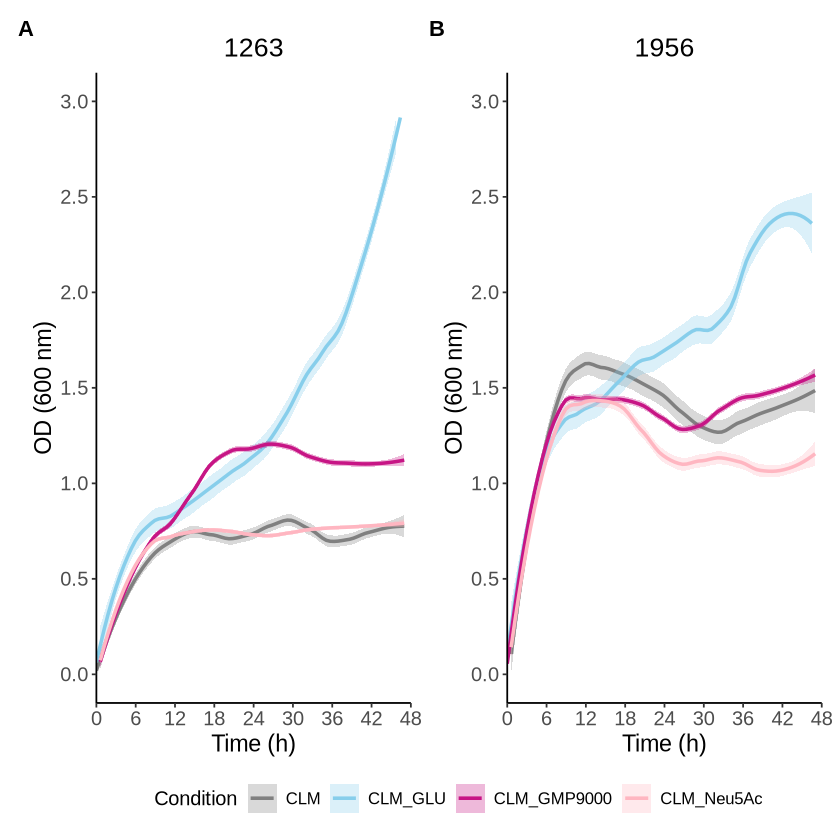

In [41]:
# Combine plots into a panel 
plot3 <- (plot1 + plot2 + 
            plot_layout(guides = "collect")) +  # collect shared legend
  plot_annotation(tag_levels = 'A') &          # A/B labels
  theme(
    legend.position = "bottom",
    plot.tag = element_text(face = "bold")     # make tags bold
  )

plot3

In [42]:
ggsave("growthcurve_300725.png", plot = plot3, width = 12, height = 6)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


In [43]:
# Plot - actual variation
plot_isolate <- function(isolate_id, data) {
  df_sub <- filter(data, Isolate == isolate_id)
  
  # Calculate max time rounded up to nearest even number for axis limits
  max_time <- ceiling(max(df_sub$Time) / 2) * 2
  
  ggplot(df_sub, aes(x = Time, y = OD_mean, color = Condition, fill = Condition)) + 
    # Real variation (SD ribbon)
    geom_ribbon(
      aes(ymin = OD_mean - OD_SD, ymax = OD_mean + OD_SD),
      alpha = 0.2, color = NA
    ) +
    # Smoothed trend line
    geom_smooth(method = "loess", span = 0.4, se = FALSE, size = 1) +
    ylab("OD (600 nm)") + 
    xlab("Time (h)") + 
    ggtitle(paste(isolate_id)) + 
    scale_color_manual(values = condition_colors) + 
    scale_fill_manual(values = condition_colors) + 
    theme_classic() +
    theme(
      plot.title = element_text(size = 16, hjust = 0.5),
      axis.title = element_text(size = 14),
      axis.text = element_text(size = 12),
      legend.title = element_text(size = 12),
      legend.text = element_text(size = 10)
    ) +
    scale_y_continuous(limits = c(0, 3), breaks = seq(0, 3, by = 0.5)) + 
    scale_x_continuous(
      limits = c(0, max_time),
      breaks = seq(0, max_time, by = 6),
      expand = c(0, 0)
    )
}

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


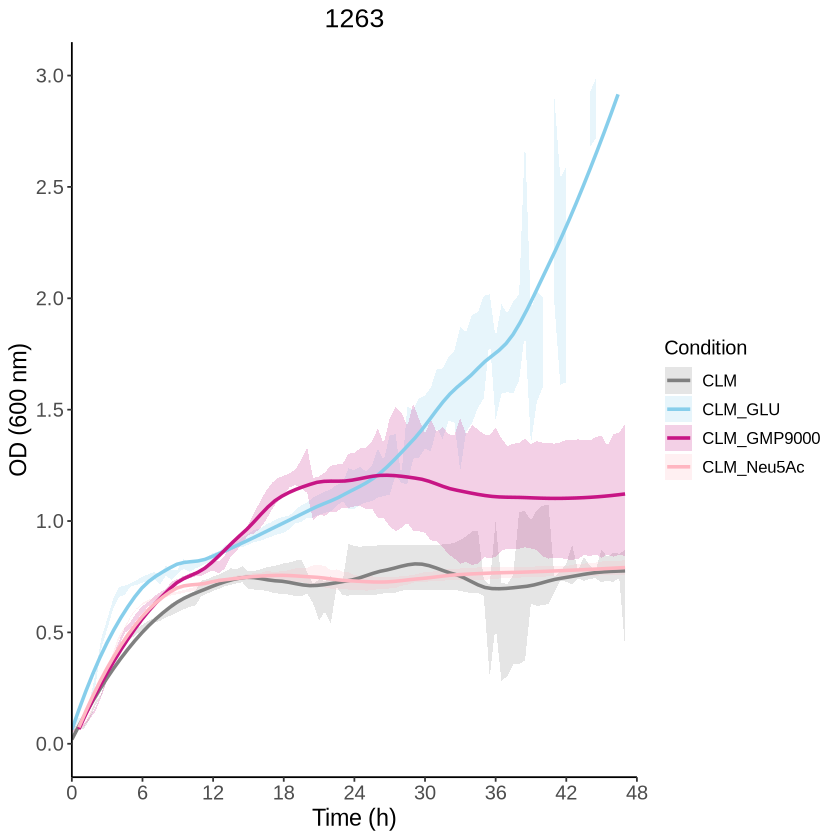

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


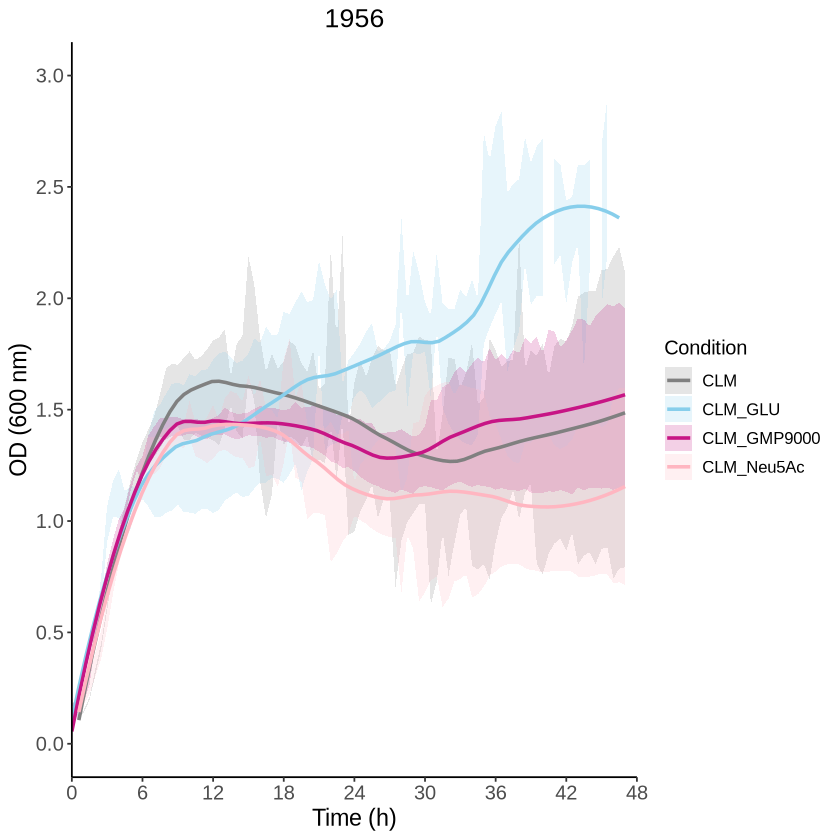

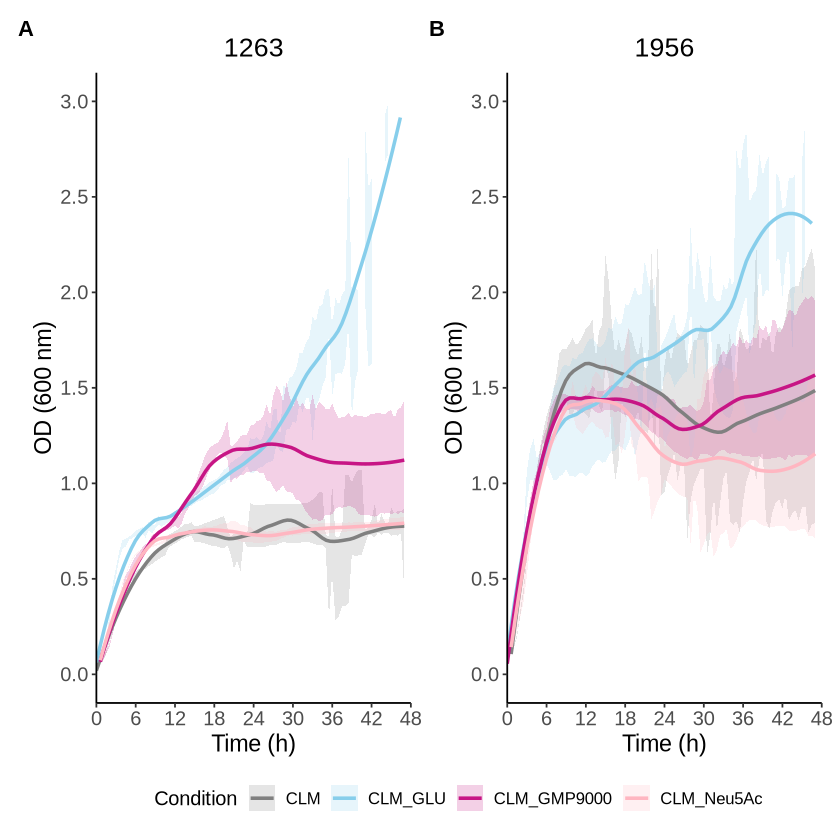

In [44]:
plot1 <- plot_isolate("1263", df_summary_filtered)
plot2 <- plot_isolate("1956", df_summary_filtered)
plot1
plot2

plot3 <- (plot1 + plot2 + 
            plot_layout(guides = "collect")) +  # collect shared legend
  plot_annotation(tag_levels = 'A') &          # A/B labels
  theme(
    legend.position = "bottom",
    plot.tag = element_text(face = "bold")     # make tags bold
  )

plot3

In [45]:
ggsave("growthcurve_300725_stdv.png", plot = plot3, width = 12, height = 6)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


In [180]:
# Code for the Black-and-White Version
plot_bw_isolate <- function(isolate_id, data) {
  df_sub <- filter(data, Isolate == isolate_id)
  
  # Calculate max time rounded up to nearest even number for axis limits
  max_time <- ceiling(max(df_sub$Time) / 2) * 2
  
  ggplot(df_sub, aes(x = Time, y = OD_mean, group = Condition, linetype = Condition)) + 
    geom_errorbar(aes(ymin = OD_mean - OD_SD, ymax = OD_mean + OD_SD), 
                  width = 0.4, color = "black") +
        geom_smooth(method = "loess", span = 0.4, se = FALSE, size = 0.8, color = "black") +
    geom_line(color = "black", size = 0.8) +
    ylab("OD (600 nm)") + 
    xlab("Time (h)") + 
    ggtitle(paste(isolate_id)) + 
    theme_classic() +
    theme(
      plot.title = element_text(size = 16, hjust = 0.5),
      axis.title = element_text(size = 14),
      axis.text = element_text(size = 12),
      legend.title = element_text(size = 12),
      legend.text = element_text(size = 10)
    ) +
    scale_y_continuous(limits = c(0, 3), breaks = seq(0, 3, by = 0.5)) + 
    scale_x_continuous(
      limits = c(0, max_time),
      breaks = seq(0, max_time, by = 6),
      expand = c(0, 0)
    ) +
    scale_linetype_manual(values = c("solid", "dashed", "dotted", "dotdash", "twodash"))
}


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_smooth()`).”


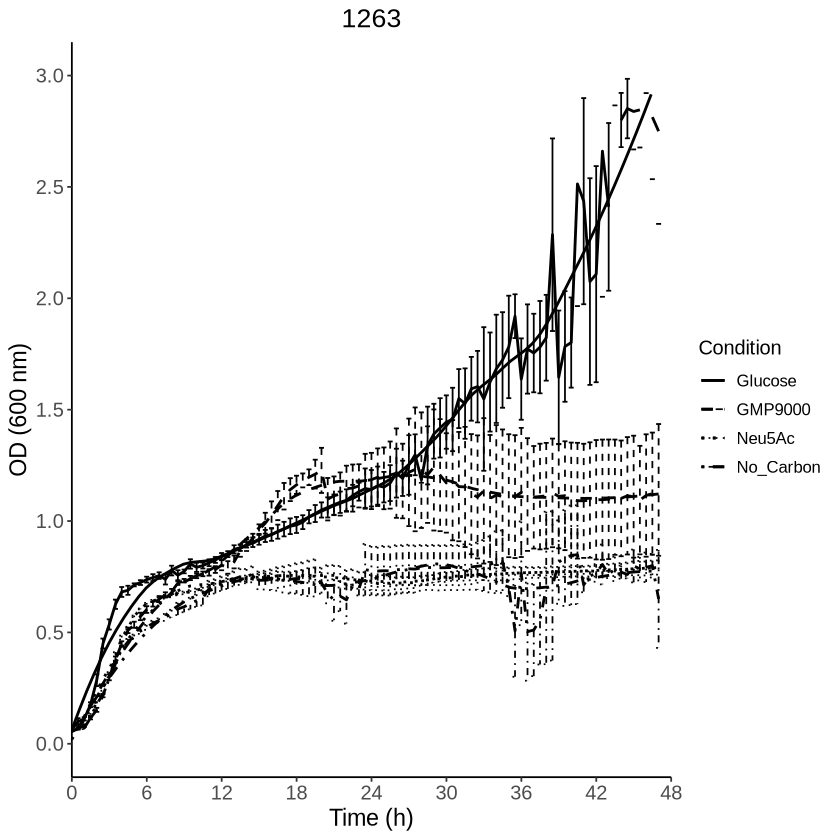

In [191]:
plot_bw_isolate("1263", df_summary_filtered)